In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
# Define constants
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0002
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import os
from PIL import Image

def load_dataset(base_dir):
    """
    Load the dataset from a directory structure where each folder contains 3 images:
    frame1 (start frame), frame2 (middle frame), and frame3 (end frame).
    
    Args:
        base_dir (str): Path to the root directory containing subfolders with images.
        
    Returns:
        list: A list of tuples where each tuple contains the paths to frame1, frame2, and frame3.
    """
    dataset = []
    
    # Traverse through each folder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        # Skip if not a directory
        if not os.path.isdir(folder_path):
            continue
        
        # Construct paths to the images
        frame1_path = os.path.join(folder_path, "frame1.jpg")
        frame2_path = os.path.join(folder_path, "frame2.jpg")
        frame3_path = os.path.join(folder_path, "frame3.jpg")
        
        # Check if all required files exist
        if os.path.exists(frame1_path) and os.path.exists(frame2_path) and os.path.exists(frame3_path):
            dataset.append((frame1_path, frame2_path, frame3_path))
        else:
            print(f"Missing files in folder: {folder_name}")
    
    return dataset


def load_images(image_paths):
    """
    Load images from the provided paths using PIL.
    
    Args:
        image_paths (list): List of tuples containing paths to frame1, frame2, and frame3.
        
    Returns:
        list: A list of tuples containing the loaded images.
    """
    images = []
    
    for frame1_path, frame2_path, frame3_path in image_paths:
        try:
            # Open images using PIL
            frame1 = Image.open(frame1_path)
            frame2 = Image.open(frame2_path)
            frame3 = Image.open(frame3_path)
            
            # Append the loaded images as a tuple
            images.append((frame1, frame2, frame3))
        except Exception as e:
            print(f"Error loading images: {e}")
    
    return images

In [7]:
# Dataset Class
class FrameDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        frame1_path, frame2_path, frame3_path = self.image_paths[idx]
        frame1 = Image.open(frame1_path)
        frame2 = Image.open(frame2_path)
        frame3 = Image.open(frame3_path)
        
        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)
        
        return frame1, frame2, frame3

# Define the generator (UNet-based)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, frame1, frame3):
        x = torch.cat((frame1, frame3), dim=1)  # Concatenate along channel dimension
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Loss Functions
adversarial_loss = nn.BCELoss().to(DEVICE)
reconstruction_loss = nn.L1Loss().to(DEVICE)

# Training Loop with Loss, Accuracy Tracking, and Model Saving
def train(generator, discriminator, dataloader, epochs, optimizer_G, optimizer_D, save_path):
    generator.train()
    discriminator.train()

    g_losses, d_losses, accuracies = [], [], []

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        correct_predictions = 0
        total_samples = 0

        for i, (frame1, frame2, frame3) in enumerate(dataloader):
            frame1, frame2, frame3 = frame1.to(DEVICE), frame2.to(DEVICE), frame3.to(DEVICE)
            
            # Adversarial ground truths
            valid = torch.ones(frame2.size(0), 1).to(DEVICE)
            fake = torch.zeros(frame2.size(0), 1).to(DEVICE)

            # Train Generator
            optimizer_G.zero_grad()
            gen_middle = generator(frame1, frame3)
            g_adv_loss = adversarial_loss(discriminator(gen_middle), valid)
            g_recon_loss = reconstruction_loss(gen_middle, frame2)
            g_loss = g_adv_loss + 0.1 * g_recon_loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(frame2), valid)
            fake_loss = adversarial_loss(discriminator(gen_middle.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Track losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

            # Track accuracy
            with torch.no_grad():
                pred_real = discriminator(frame2).round()
                pred_fake = discriminator(gen_middle).round()
                correct_predictions += (pred_real == valid).sum().item() + (pred_fake == fake).sum().item()
                total_samples += 2 * frame2.size(0)

            # print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Calculate average losses and accuracy
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_d_loss = epoch_d_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        # Store metrics
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Generator Loss = {avg_g_loss:.4f}, Discriminator Loss = {avg_d_loss:.4f}, Accuracy = {accuracy:.4f}")

    # Save models at the end of training
    torch.save(generator.state_dict(), os.path.join(save_path, "generator.pth"))
    torch.save(discriminator.state_dict(), os.path.join(save_path, "discriminator.pth"))
    print(f"Models saved to {save_path}")

    return g_losses, d_losses, accuracies

# Plotting Function
def plot_metrics(g_losses, d_losses, accuracies):
    epochs = range(1, len(g_losses) + 1)

    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, g_losses, label="Generator Loss")
    plt.plot(epochs, d_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Load dataset
base_dir = "datasets/train_10k"
image_paths = load_dataset(base_dir)

In [11]:
transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
dataset = FrameDataset(image_paths, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [13]:
 # Train models
g_losses, d_losses, accuracies = train(generator, discriminator, dataloader, EPOCHS, optimizer_G, optimizer_D,'Saving/')

Epoch 1: Generator Loss = 3.1664, Discriminator Loss = 0.2887, Accuracy = 0.9459
Epoch 2: Generator Loss = 3.2355, Discriminator Loss = 0.3443, Accuracy = 0.9387
Epoch 3: Generator Loss = 2.8069, Discriminator Loss = 0.3779, Accuracy = 0.9288
Epoch 4: Generator Loss = 2.4316, Discriminator Loss = 0.3578, Accuracy = 0.9146
Epoch 5: Generator Loss = 2.3657, Discriminator Loss = 0.3464, Accuracy = 0.9198
Epoch 6: Generator Loss = 1.8209, Discriminator Loss = 0.4334, Accuracy = 0.8824
Epoch 7: Generator Loss = 2.0836, Discriminator Loss = 0.4135, Accuracy = 0.9017
Epoch 8: Generator Loss = 1.7881, Discriminator Loss = 0.4072, Accuracy = 0.8921
Epoch 9: Generator Loss = 2.2278, Discriminator Loss = 0.3451, Accuracy = 0.9223
Epoch 10: Generator Loss = 2.2603, Discriminator Loss = 0.3537, Accuracy = 0.9180
Epoch 11: Generator Loss = 2.0910, Discriminator Loss = 0.3569, Accuracy = 0.9164
Epoch 12: Generator Loss = 2.0833, Discriminator Loss = 0.3640, Accuracy = 0.9169
Epoch 13: Generator Loss 

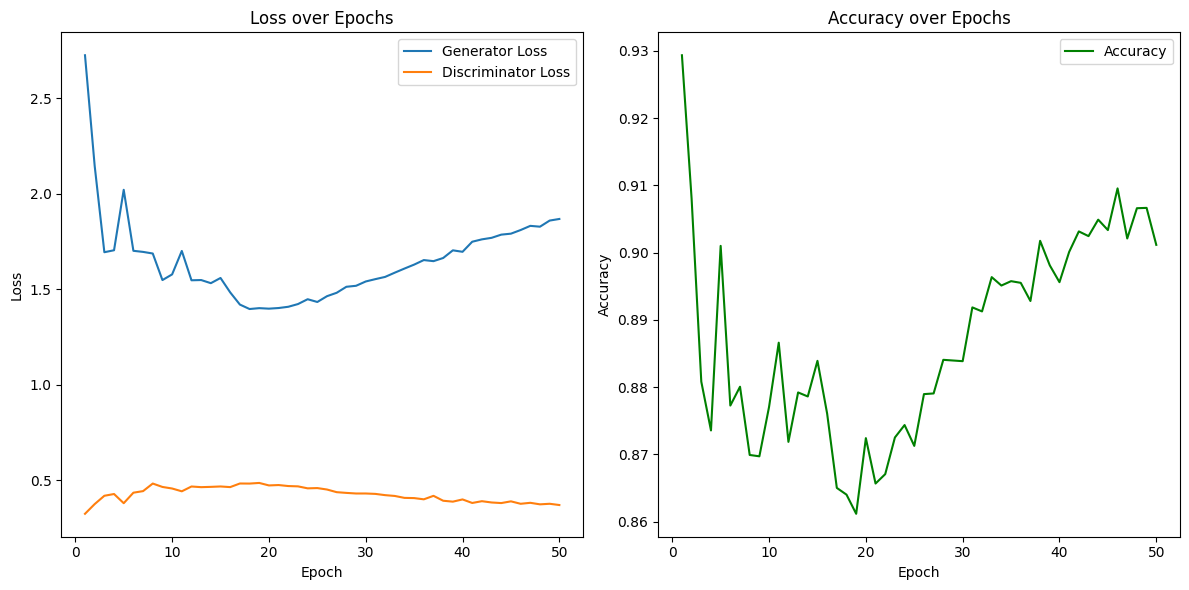

In [ ]:
    # Plot metrics
plot_metrics(g_losses, d_losses, accuracies)

In [14]:
generator.load_state_dict(torch.load('/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/Saving/generator.pth'))
generator.eval()


/tmp/ipykernel_96172/3607868809.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/home/pcn/Desktop/Rafey/In-Between-Frame-Generation

Generator(
  (encoder): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [15]:
# Finding the MSE score for the test dataset
def test_model(generator, dataloader):
    total_mse = 0
    total_samples = 0

    with torch.no_grad():
        for frame1, frame2, frame3 in dataloader:
            frame1, frame2, frame3 = frame1.to(DEVICE), frame2.to(DEVICE), frame3.to(DEVICE)
            gen_middle = generator(frame1, frame3)
            mse = nn.MSELoss(reduction="sum")(gen_middle, frame2)
            total_mse += mse.item()
            total_samples += frame2.numel()

    avg_mse = total_mse / total_samples
    return avg_mse

# Load test dataset
base_dir = "/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/datasets/test_2k_original"
test_image_paths = load_dataset(base_dir)
test_dataset = FrameDataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the model
mse_score = test_model(generator, test_dataloader)
print(f"Mean Squared Error on Test Dataset: {mse_score:.4f}")


Mean Squared Error on Test Dataset: 0.0061
